# Проект "Маркетинг"

**Цель проекта** - разработать модель машинного обучения, которая на основании данных о прошлых покупках и рекламных кампаниях будет предсказывать вероятность совершения покупки пользователем в течение 90 дней.

**Входные данные**
1. Данные о покупках пользователей.
   - Идентификатор пользователя (client_id)
   - Количество приобретаемых товаров (quantity)
   - Цена товара (price)
   - Категория приобретаемого товара (category_ids)
   - Дата покупки (date)
   - Идентификатор коммуникации с пользователем, благодаря которому покупка была совершена (message_id)
2. Данные о рекламных коммуникациях с пользователями.
   - Идентификатор рекламной кампании (bulk_campaign_id)
   - Идентификатор пользователя (client_id)
   - Идентификатор рекламной коммуникации (message_id)
   - Действие пользователя в результате рекламной коммуникации (event)
   - Способ рекламной коммуникации (channel)
   - Дата действия пользователя (date)
   - Дата коммуникации (created_at) 

**План работы**
1. Поверхностный обзор данных.
2. Предобработка данных.
3. Исследовательский анализ данных (EDA).
4. Создание новых признаков.
5. Корреляционный анализ данных.
6. Построение моделей машинного обучения.
7. Исследование значимости признаков.

## Импорты

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import is_classifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [6]:
RANDOM_STATE = 42

## Поверхностный обзор данных

In [8]:
# утилитная функция для открытия файла csv
def csv_reader(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Ошибка: Файл '{file_path}' не найден.")
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        raise RuntimeError(f"Непредвиденная ошибка: {e}")

In [9]:
# получение данных из входных файлов
df_messages = csv_reader("data/apparel-messages.csv")
df_purchases = csv_reader("data/apparel-purchases.csv")
df_target = csv_reader("data/apparel-target_binary.csv")

In [10]:
# общая информация по датасету
df_messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [11]:
# общая информация по датасету
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [12]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   .client_id  49849 non-null  int64
 1   target      49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [13]:
# вывод 3 случайных записей
df_messages.sample(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
3514533,9232,1515915625489802736,1515915625489802736-9232-63b7f13ee94d8,send,mobile_push,2023-01-06,2023-01-06 10:19:39
11754092,14507,1515915625508146101,1515915625508146101-14507-65ab6fb744afc,send,mobile_push,2024-01-20,2024-01-20 07:10:02
2689639,8131,1515915625559676742,1515915625559676742-8131-637f837c876f5,send,mobile_push,2022-11-24,2022-11-24 14:55:43


In [14]:
# вывод 3 случайных записей
df_purchases.sample(3)

,client_id,quantity,price,category_ids,date,message_id
35218,1515915625491024926,1,1499.0,"['2', '18', '344', '445']",2022-08-31,1515915625491024926-6223-630c908d7b963
175809,1515915625584257577,1,1062.0,"['4', '29', '310', '500']",2023-11-09,1515915625998307103-14081-654ccc8e07597
88286,1515915625535966195,1,1749.0,"['4', '28', '62', '656']",2023-03-04,1515915625535966195-10619-6401de90d1e03


In [15]:
# количество дубликатов в датасете с коммуникациями
print(df_messages.duplicated().sum())
print(df_purchases.duplicated().sum())

48610
73020


<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Промежуточные выводы о данных:
1. Пропуски во всех датасетах отсутствуют.
2. Есть дубликаты в датасете с данными о рекламных коммуникациях с пользователями (48610 дублей). 
3. В датасете с покупками также есть полные дубликаты (73020 дублей) - вероятнее всего была какая-то техническая специфика при сборе этих данных, что повлекло за собой наличие полных дубликатов.

</div>

In [17]:
# количество рекламных коммуникаций 
len(df_messages)

12739798

In [18]:
# обзор столбца event
df_messages['event'].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

In [19]:
# обзор столбца channel
df_messages['channel'].value_counts()

channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

In [20]:
# обзор столбца date
print(df_messages['date'].min())
print(df_messages['date'].max())

2022-05-19
2024-02-15


In [21]:
# обзор столбца client_id
df_messages['client_id'].nunique()

53329

In [22]:
# обзор столбца bulk_campaign_id
df_messages['bulk_campaign_id'].nunique()

2709

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">

Датасет с рекламными коммуникациями:
1. В наличии данные за промежуток с 19.05.2022 по 15.02.2024 (всего 12_739_798 наблюдений), включая 48610 дублей.
2. Всего было сделано 2709 рекламных кампаний в адрес 53329 пользователей.
3. Рекламные коммуникации осуществляются при помощи мобильных пуш-уведомлений и через электронную почту.
4. Действия пользователя в рамках рекламной коммуникации могут быть следующими:
   - send (уведомление отправлено, но реакции пользователя нет)
   - open (пользователь открыл рекламное уведомление)
   - click (пользователь перешел по ссылке в рекламном уведомлении)
   - purchase (пользователь приобрел товар в рамках рекламного уведомления)
   - hard_bounce (ошибка доставки, контактные данные получателя невалидны)
   - soft_bounce (временная ошибка доставки)
   - unsubscribe (отказ от дальнейший коммуникаций)
   - hbq_spam (сообщение распознано как спам на уровне программного обеспечения)
   - complain (жалоба пользователя на спам)
   - subscribe (подписка пользователя)
   - close (не очень понятное действие)

</div>

In [24]:
# количество покупок 
len(df_purchases)

202208

In [25]:
# обзор столбца date
print(df_purchases['date'].min())
print(df_purchases['date'].max())

2022-05-16
2024-02-16


In [26]:
# обзор столбца quantity
df_purchases['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

In [27]:
# обзор столбца client_id
df_purchases['client_id'].nunique()

49849

In [28]:
# обзор столбца message_id
df_purchases['message_id'].nunique()

50204

In [29]:
# обзор столбца category_ids
df_purchases['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

<div style="background-color: #f0f7ff; border-left: 6px solid #2980b9; padding: 15px; color: #1a237e; font-weight: 600; font-size: 1.05em; margin: 10px 0;">
    
Датасет с покупками:
1. В наличии данные за промежуток с 16.05.2022 по 16.02.2024 (всего 202_208 наблюдений), включая 73020 дублей.
2. Количество приобретаемого товара находится в промежутке от 1 до 30 штук.
3. В датасете представлены данные по 49849 уникальным пользователям.
4. В датасете представлены покупки, которые были сделаны на основании 50204 рекламных коммуникаций с пользователями.
5. Каждая покупка может быть описана при помощи 4-уровневой категории товара. 

</div>

## Предобработка данных

In [32]:
# удаляем дубликаты
df_purchases.drop_duplicates(inplace=True)
df_purchases = df_purchases.reset_index(drop=True)

df_messages.drop_duplicates(inplace=True)
df_messages = df_messages.reset_index(drop=True)

In [33]:
# проверка количества дубликатов после удаления
print(df_purchases.duplicated().sum())
print(df_messages.duplicated().sum())

0
0


In [34]:
# преобразование в datetime
df_purchases['date'] = pd.to_datetime(df_purchases['date'])
df_messages['date'] = pd.to_datetime(df_messages['date'])

In [35]:
# переименование столбца с целевым признаком
df_target = df_target.rename(columns={'.client_id': 'client_id'})

## Исследовательский анализ данных (EDA)

### Количество продаж по месяцам

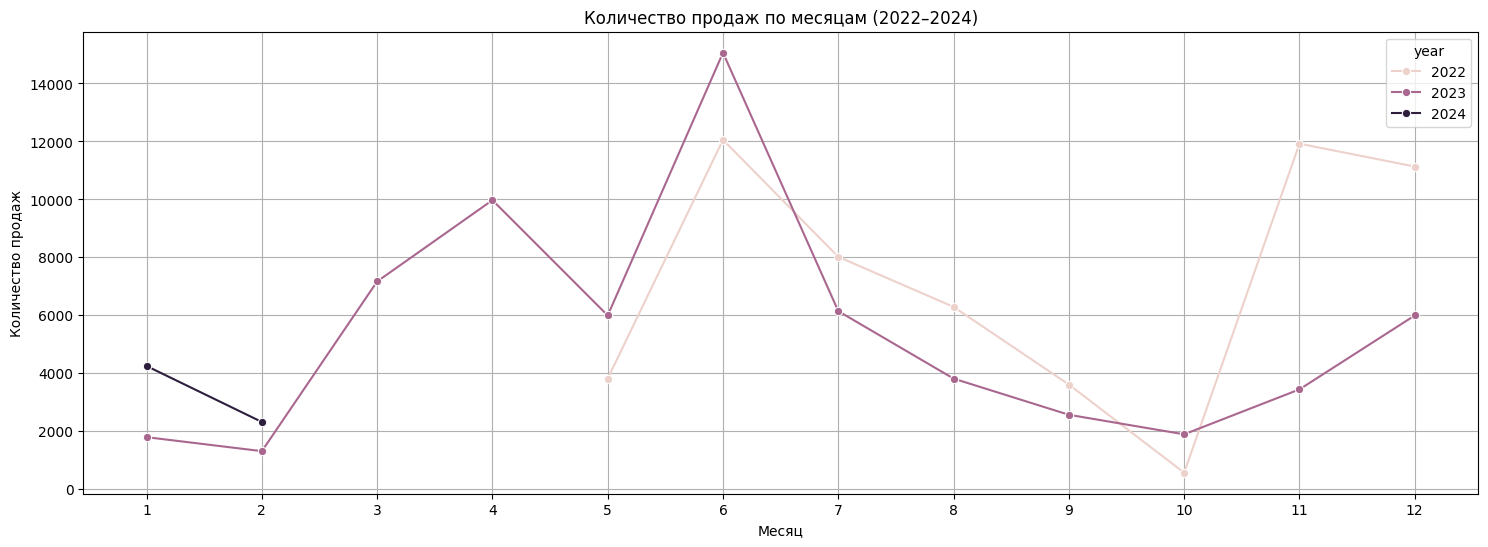

In [38]:
df_purchases['year'] = df_purchases['date'].dt.year
df_purchases['month'] = df_purchases['date'].dt.month

monthly_sales = df_purchases.groupby(['year', 'month']).size().reset_index(name='purchases_count')

plt.figure(figsize=(18, 6))

sns.lineplot(
    data=monthly_sales,
    x='month',
    y='purchases_count',
    hue='year',
    marker='o'
)

plt.xticks(range(1, 13))
plt.xlabel('Месяц')
plt.ylabel('Количество продаж')
plt.title('Количество продаж по месяцам (2022–2024)')
plt.grid(True)
plt.show()

### Количество реакций на рекламные коммуникации

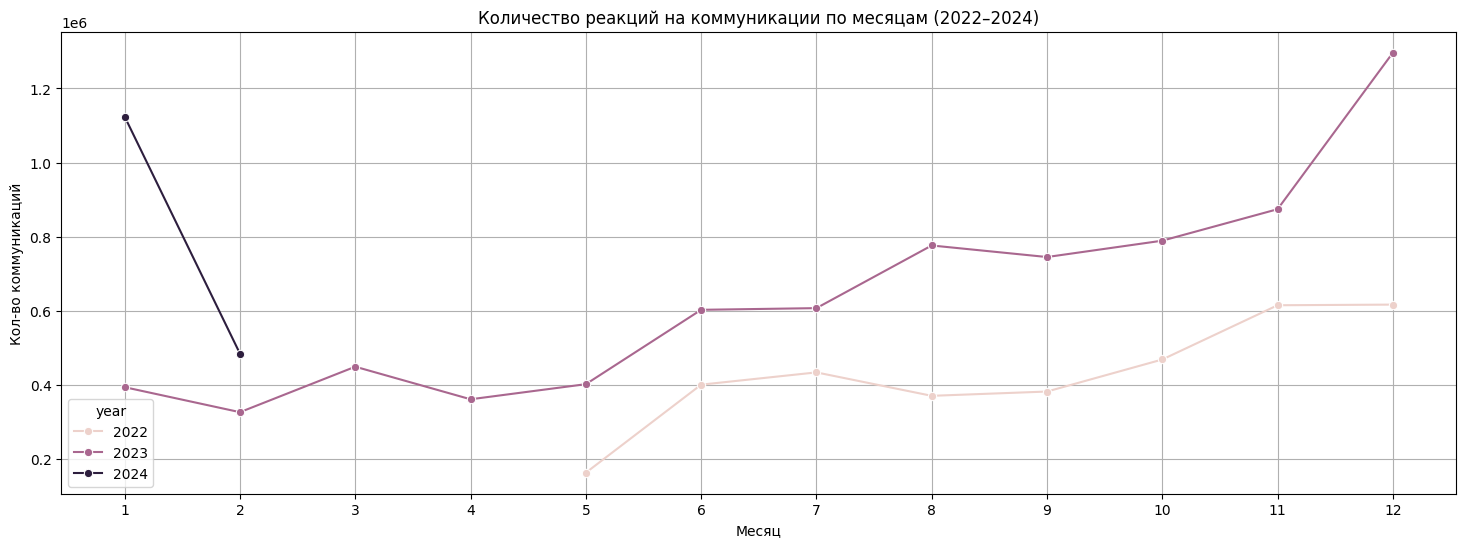

In [40]:
df_messages['year'] = df_messages['date'].dt.year
df_messages['month'] = df_messages['date'].dt.month

monthly_messages = df_messages.groupby(['year', 'month'], observed=True)['message_id'].size().reset_index(name='messages_count')

plt.figure(figsize=(18, 6))

sns.lineplot(
    data=monthly_messages,
    x='month',
    y='messages_count',
    hue='year',
    marker='o'
)

plt.xticks(range(1, 13))
plt.xlabel('Месяц')
plt.ylabel('Кол-во коммуникаций')
plt.title('Количество реакций на коммуникации по месяцам (2022–2024)')
plt.grid(True)
plt.show()

### Количество рекламных коммуникаций с покупкой

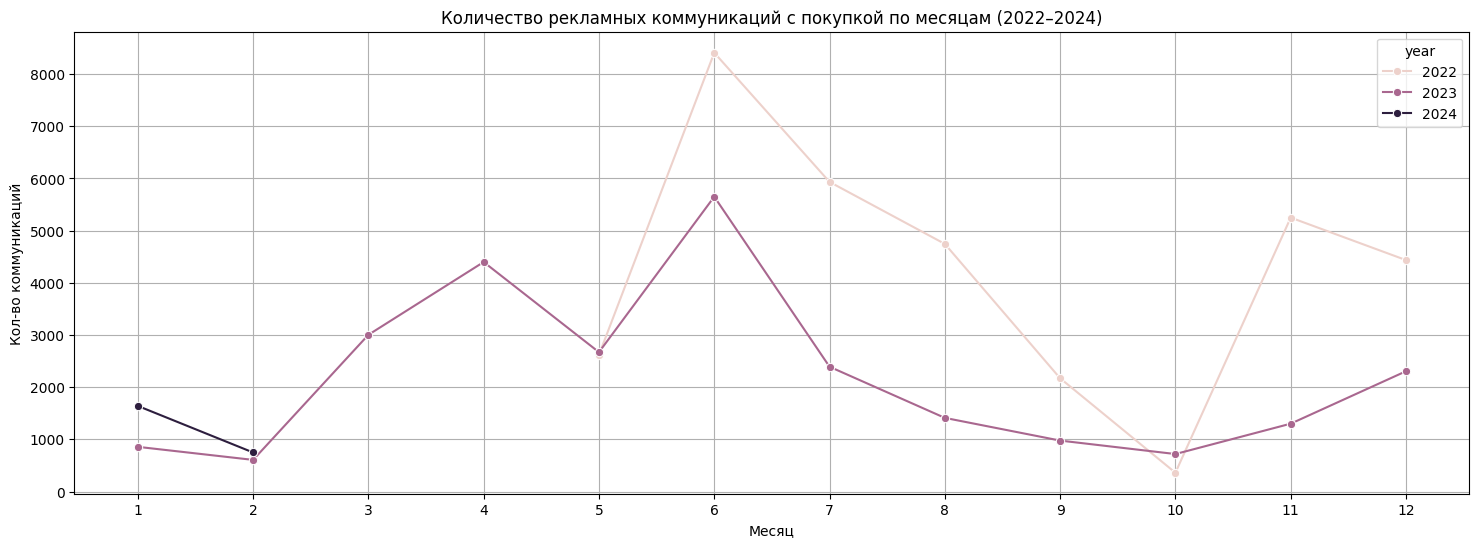

In [42]:
df_successful_messages = df_messages[df_messages['event'] == 'purchase'].copy()

monthly_messages = df_successful_messages.groupby(['year', 'month'])['message_id'].size().reset_index(name='messages_count')

plt.figure(figsize=(18, 6))

sns.lineplot(
    data=monthly_messages,
    x='month',
    y='messages_count',
    hue='year',
    marker='o'
)

plt.xticks(range(1, 13))
plt.xlabel('Месяц')
plt.ylabel('Кол-во коммуникаций')
plt.title('Количество рекламных коммуникаций с покупкой по месяцам (2022–2024)')
plt.grid(True)
plt.show()

### Способ рекламной коммуникации

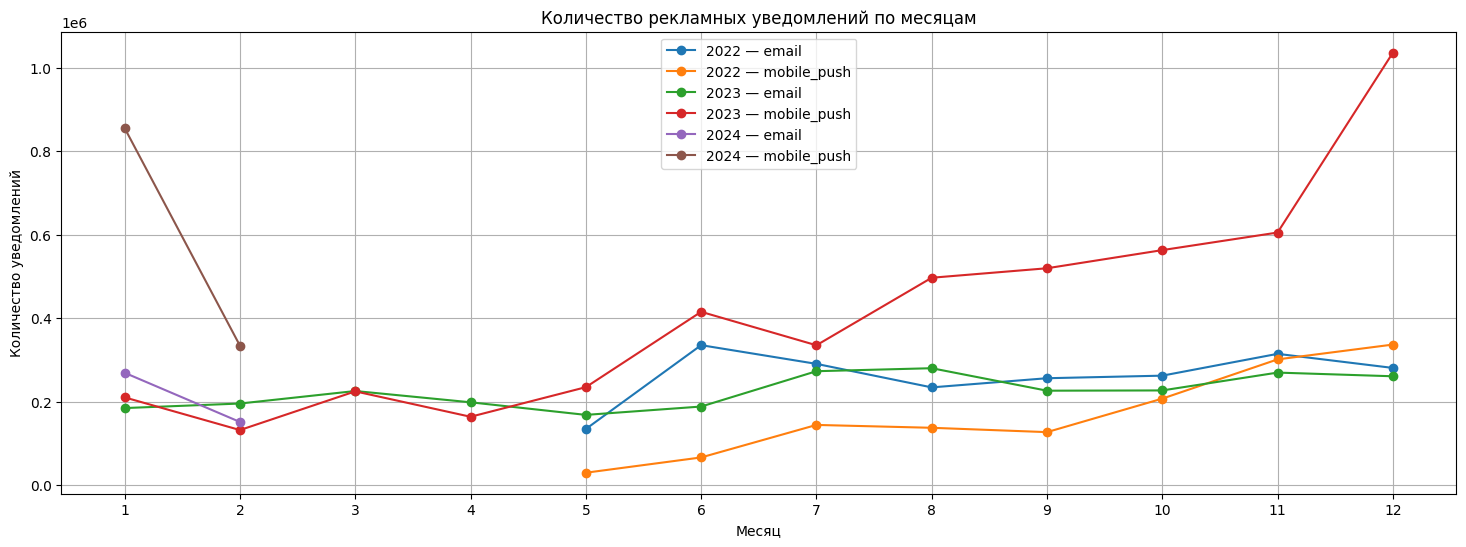

In [44]:
agg = (
    df_messages.groupby(['year', 'month', 'channel'], observed=True)
      .size()
      .reset_index(name='cnt')
)

plt.figure(figsize=(18, 6))

years = [2022, 2023, 2024]
channels = ['email', 'mobile_push']

for year in years:
    for channel in channels:
        data = agg[(agg['year'] == year) & (agg['channel'] == channel)]
        plt.plot(
            data['month'],
            data['cnt'],
            marker='o',
            label=f'{year} — {channel}'
        )

plt.title('Количество рекламных уведомлений по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество уведомлений')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)

plt.show()

### Реакция пользователей на рекламную коммуникацию

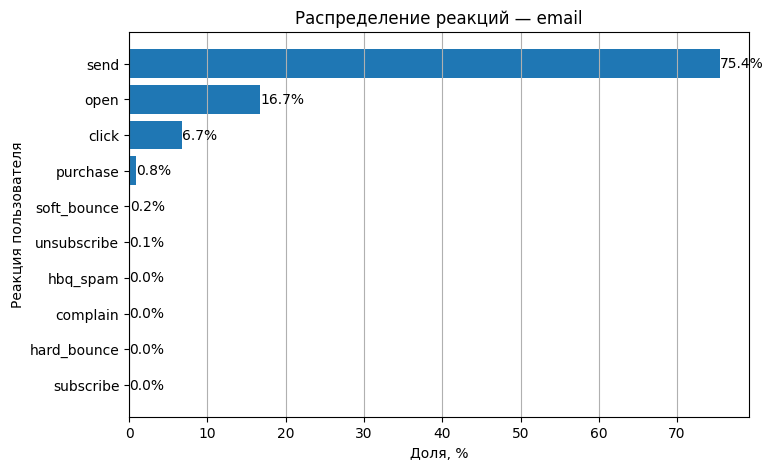

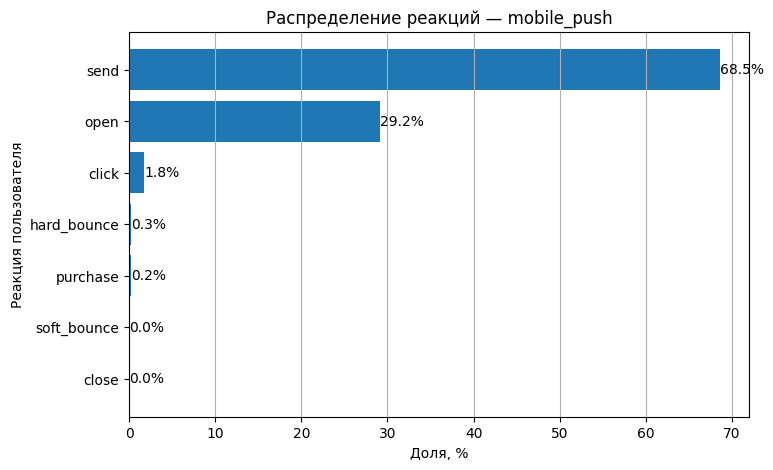

In [46]:
channels = ['email', 'mobile_push']

for channel in channels:
    counts = (
        df_messages[df_messages['channel'] == channel]
        .groupby('event')
        .size()
        .sort_values()
    )

    percents = counts / counts.sum() * 100

    plt.figure(figsize=(8, 5))
    plt.barh(percents.index, percents.values)

    for i, v in enumerate(percents.values):
        plt.text(v, i, f'{v:.1f}%', va='center')

    plt.title(f'Распределение реакций — {channel}')
    plt.xlabel('Доля, %')
    plt.ylabel('Реакция пользователя')
    plt.grid(axis='x')

    plt.show()

### Реакция пользователей на рекламную коммуникацию в части сделанных покупок 

In [48]:
df_result = df_purchases.merge(
    df_messages,
    on="message_id",
    how="inner"
)

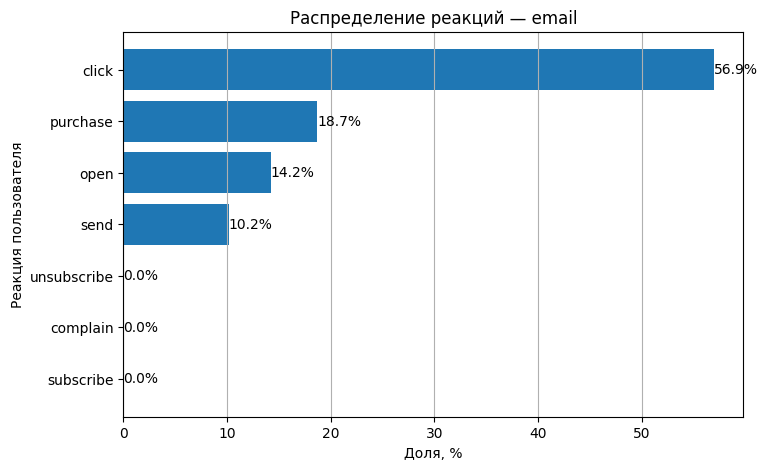

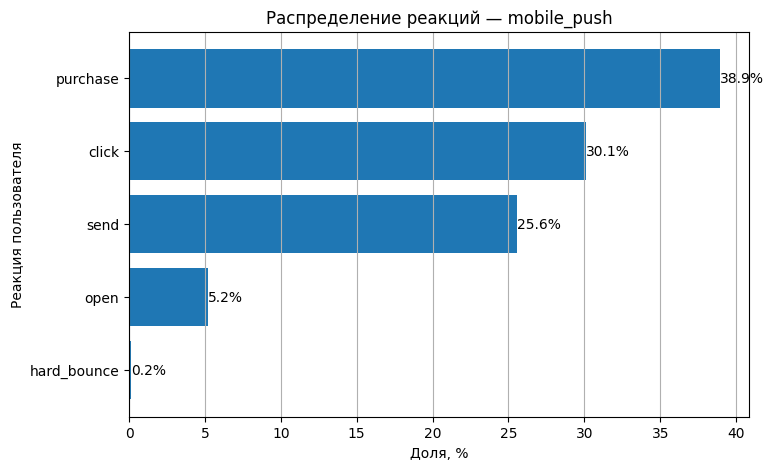

In [49]:
channels = ['email', 'mobile_push']

for channel in channels:
    counts = (
        df_result[df_result['channel'] == channel]
        .groupby('event')
        .size()
        .sort_values()
    )

    percents = counts / counts.sum() * 100

    plt.figure(figsize=(8, 5))
    plt.barh(percents.index, percents.values)

    for i, v in enumerate(percents.values):
        plt.text(v, i, f'{v:.1f}%', va='center')

    plt.title(f'Распределение реакций — {channel}')
    plt.xlabel('Доля, %')
    plt.ylabel('Реакция пользователя')
    plt.grid(axis='x')

    plt.show()

## Создание новых признаков

### Сумма покупок по месяцам

In [52]:
df = (
    df_purchases
    .groupby(['client_id', 'year', 'month'])
    .size()
    .reset_index(name='purchases_count')
    .pivot(index='client_id', columns=['year', 'month'], values='purchases_count')
    .fillna(0)
)

# делаем плоские названия столбцов
df.columns = [f'{year}_{month:02d}' for year, month in df.columns]

df = df.reset_index()

### Количество рекламных коммуникаций по месяцам

In [54]:
msg_counts = (
    df_messages
    .groupby(['client_id', 'year', 'month', 'channel'])
    .size()
    .reset_index(name='cnt')
    .pivot_table(
        index='client_id',
        columns=['year', 'month', 'channel'],
        values='cnt',
        fill_value=0
    )
)

# делаем плоские названия столбцов
msg_counts.columns = [f'{year}_{month:02d}_{channel}' for year, month, channel in msg_counts.columns]

msg_counts = msg_counts.reset_index()

In [55]:
df = df.merge(msg_counts, on='client_id', how='left')

# заполняем NaN нулями, если клиент не получал сообщений
df.fillna(0, inplace=True)

### Доля покупок среди рекламных коммуникаций за месяц

In [57]:
reaction_counts = (
    df_messages
    .groupby(['client_id', 'channel', 'event'])
    .size()
    .reset_index(name='total_events')
)

In [58]:
pivot_df = reaction_counts.pivot_table(
    index='client_id',
    columns='event',
    values='total_events',
    fill_value=0
).reset_index()

# Вычисляем долю purchase от send, подставляем NaN если send == 0
pivot_df['purchase_ratio'] = np.where(
    pivot_df['send'] == 0,
    0,
    pivot_df['purchase'] / pivot_df['send']
)

df = df.merge(
    pivot_df[['client_id', 'purchase_ratio']], 
    on='client_id', 
    how='inner'
)

### Среднее время между покупками

In [60]:
# 1️⃣ Количество уникальных дней покупки
unique_purchase_days = df_purchases.groupby('client_id')['date'].nunique().reset_index()
unique_purchase_days.rename(columns={'date': 'unique_purchase_days'}, inplace=True)

# 2️⃣ Сортируем и убираем дубликаты по дню
df_unique_days = df_purchases.sort_values(['client_id', 'date']).drop_duplicates(subset=['client_id', 'date']).copy()

# 3️⃣ Вычисляем разницу между датами
df_unique_days['days_since_last'] = df_unique_days.groupby('client_id')['date'].diff().dt.days

# 4️⃣ Среднее время между покупками
avg_days_between = df_unique_days.groupby('client_id')['days_since_last'].mean().reset_index()
avg_days_between.rename(columns={'days_since_last': 'avg_days_between_purchases'}, inplace=True)

# 5️⃣ Объединяем с количеством уникальных дней и ставим -1, если только один день покупки
avg_days_between = avg_days_between.merge(unique_purchase_days, on='client_id', how='left')
avg_days_between.loc[avg_days_between['unique_purchase_days'] == 1, 'avg_days_between_purchases'] = -1

# 6️⃣ Оставляем только нужные столбцы
avg_days_between = avg_days_between[['client_id', 'avg_days_between_purchases']]

# 7️⃣ Если в df уже есть столбец avg_days_between_purchases, удаляем его, чтобы избежать конфликта
if 'avg_days_between_purchases' in df.columns:
    df = df.drop(columns=['avg_days_between_purchases'])

# 8️⃣ Добавляем новый столбец в основной df
df = df.merge(avg_days_between, on='client_id', how='left')

# 9️⃣ Для клиентов без покупок тоже ставим -1
df['avg_days_between_purchases'] = df['avg_days_between_purchases'].fillna(-1)

### Количество дней с момента последней покупки

In [62]:
reference_date = pd.to_datetime('2024-02-17')

# Последняя дата покупки каждого клиента
last_purchase = df_purchases.groupby('client_id')['date'].max().reset_index()
last_purchase.rename(columns={'date': 'last_purchase_date'}, inplace=True)

# Вычисляем количество дней с последней покупки
last_purchase['days_since_last_purchase'] = (reference_date - last_purchase['last_purchase_date']).dt.days

# Оставляем только нужные столбцы
last_purchase = last_purchase[['client_id', 'days_since_last_purchase']]

# Если в df уже есть столбец, удаляем его
if 'days_since_last_purchase' in df.columns:
    df = df.drop(columns=['days_since_last_purchase'])

# Добавляем в основной df
df = df.merge(last_purchase, on='client_id', how='left')

# Для клиентов без покупок ставим -1
df['days_since_last_purchase'] = df['days_since_last_purchase'].fillna(-1)

print(df.head())

df_purchases.query('client_id == 1515915625468061100')

             client_id  2022_05  2023_01  2024_02  2023_03  2023_06  2022_07  \
0  1515915625468060902      5.0      0.0      0.0      0.0      0.0      0.0   
1  1515915625468061003      0.0      6.0      0.0      0.0      0.0      0.0   
2  1515915625468061099      1.0      0.0      0.0      0.0      0.0      0.0   
3  1515915625468061100      0.0      0.0      1.0      0.0      0.0      0.0   
4  1515915625468061170      0.0      0.0      0.0      7.0      1.0      0.0   

   2022_08  2022_11  2022_12  ...  2023_11_mobile_push  2023_12_email  \
0      0.0      0.0      0.0  ...                  0.0           11.0   
1      0.0      0.0      0.0  ...                  0.0            5.0   
2      0.0      0.0      0.0  ...                  0.0            9.0   
3      0.0      0.0      0.0  ...                 33.0            0.0   
4      0.0      0.0      0.0  ...                 19.0           13.0   

   2023_12_mobile_push  2024_01_email  2024_01_mobile_push  2024_02_email  \
0  

,client_id,quantity,price,category_ids,date,message_id,year,month
127847,1515915625468061100,1,1049.0,"['4', '27', '1828', '5717']",2024-02-10,1515915625468061100-14623-65c5c55eeb9e0,2024,2


### Количество покупок за последние 90 дней

In [64]:
reference_date = pd.to_datetime('2024-02-17')
days_window = 90
start_date = reference_date - pd.Timedelta(days=days_window)

# df_purchases содержит столбцы client_id и date
df_purchases['date'] = pd.to_datetime(df_purchases['date'])

# Считаем покупки за последние 90 дней
purchases_90d = df_purchases[(df_purchases['date'] >= start_date) & (df_purchases['date'] <= reference_date)]

# Считаем количество покупок по клиентам
purchases_count_90d = purchases_90d.groupby('client_id').size().reset_index(name='purchases_last_90_days')

# Если в df уже есть этот столбец, удаляем, чтобы избежать конфликта
if 'purchases_last_90_days' in df.columns:
    df = df.drop(columns=['purchases_last_90_days'])

# Добавляем в основной df
df = df.merge(purchases_count_90d, on='client_id', how='left')

# Для клиентов без покупок в последние 90 дней ставим 0
df['purchases_last_90_days'] = df['purchases_last_90_days'].fillna(0)

df.head()

,client_id,2022_05,2023_01,2024_02,2023_03,2023_06,2022_07,2022_08,2022_11,2022_12,...,2023_12_email,2023_12_mobile_push,2024_01_email,2024_01_mobile_push,2024_02_email,2024_02_mobile_push,purchase_ratio,avg_days_between_purchases,days_since_last_purchase,purchases_last_90_days
0,1515915625468060902,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,0.0,13.0,0.0,0.0,0.0,0.039683,-1.0,631,0.0
1,1515915625468061003,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,5.0,0.0,4.0,0.0,0.006494,-1.0,409,0.0
2,1515915625468061099,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,12.0,0.0,5.0,0.0,0.000000,-1.0,641,0.0
3,1515915625468061100,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,60.0,0.0,31.0,0.0,25.0,0.003745,-1.0,7,1.0
4,1515915625468061170,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,...,13.0,35.0,13.0,28.0,7.0,7.0,0.024691,41.5,245,0.0


## Обучение моделей

In [66]:
df = df.merge(df_target, on='client_id', how='inner')

In [67]:
X = df.drop(['target', 'client_id'], axis=1) 
y = df['target']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y)

In [69]:
# decision tree
pipe_dt = Pipeline([
    ('scaler', 'passthrough'),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_dt = {
    'model__max_depth': [5, 10, 15],
    'model__min_samples_split': [2, 10, 20],
}

# random forest
pipe_rf = Pipeline([
    ('scaler', 'passthrough'),
    ('model', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

param_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 15],
}

# knn
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

param_knn = {
    'model__n_neighbors': [5, 7, 9],
}

# svc 
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(
        kernel='rbf',
        gamma='scale',
        probability=False,
        random_state=RANDOM_STATE
    ))
])

param_svc = {
    'model__C': [0.1, 1, 10],
}

# catboost 
pipe_cat = Pipeline([
    ('scaler', 'passthrough'),
    ('model', CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        loss_function='Logloss',
        iterations=150
    ))
])

param_cat = {
    'model__depth': [4, 6],
    'model__learning_rate': [0.03, 0.1],
}

# XGBoost
pipe_xgb = Pipeline([
    ('scaler', 'passthrough'),
    ('model', XGBClassifier(
        random_state=RANDOM_STATE,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        n_jobs=-1
    ))
])

param_xgb = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.03, 0.1],
}

# LightGBM
pipe_lgbm = Pipeline([
    ('scaler', 'passthrough'),
    ('model', LGBMClassifier(
        random_state=RANDOM_STATE,
        objective='binary',
        n_jobs=-1
    ))
])

param_lgbm = {
    'model__learning_rate': [0.03, 0.1],
    'model__max_depth': [-1, 10, 20]
}

In [70]:
# baseline search
search_spaces = {
    'DecisionTree': (pipe_dt, param_dt),
    'RandomForest': (pipe_rf, param_rf),
    'KNN': (pipe_knn, param_knn),
    'SVC': (pipe_svc, param_svc),
    'CatBoost': (pipe_cat, param_cat),
    'XGBoost': (pipe_xgb, param_xgb),
    'LightGBM': (pipe_lgbm, param_lgbm)
}

results = {}

for name, (pipe, params) in search_spaces.items():
    print(f'\n{name}')
    
    search = GridSearchCV(
        pipe,
        param_grid=params,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    results[name] = search.best_score_
    
    print(f'ROC-AUC: {search.best_score_:.4f}')



DecisionTree
ROC-AUC: 0.6824

RandomForest
ROC-AUC: 0.7299

KNN
ROC-AUC: 0.5718

SVC
ROC-AUC: 0.6010

CatBoost
ROC-AUC: 0.7408

XGBoost
ROC-AUC: 0.7440

LightGBM
[LightGBM] [Info] Number of positive: 592, number of negative: 28795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 29387, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.020145 -> initscore=-3.884450
[LightGBM] [Info] Start training from score -3.884450
ROC-AUC: 0.7314


In [71]:
# выбор лучшей модели
sorted(results.items(), key=lambda x: x[1], reverse=True)

[('XGBoost', np.float64(0.7439664647550307)),
 ('CatBoost', np.float64(0.7408074809652216)),
 ('LightGBM', np.float64(0.7314014338838172)),
 ('RandomForest', np.float64(0.7298507138997906)),
 ('DecisionTree', np.float64(0.6824018676105829)),
 ('SVC', np.float64(0.6010009159831671)),
 ('KNN', np.float64(0.5718266986298733))]

In [72]:
# cat boost tuning
pipe_cat_final = Pipeline([
    ('scaler', 'passthrough'),
    ('model', CatBoostClassifier(
        random_state=RANDOM_STATE,
        verbose=0,
        loss_function='Logloss',
        early_stopping_rounds=30
    ))
])

param_cat_final = {
    'model__iterations': [200, 400],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.03, 0.1],
    'model__l2_leaf_reg': [1, 3, 5],
}

search_cat = RandomizedSearchCV(
    pipe_cat_final,
    param_cat_final,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

search_cat.fit(X_train, y_train)

print('Лучшие гиперпараметры CatBoost:\n')
for param, value in search_cat.best_params_.items():
    print(f'{param}: {value}')

print(f'\nЛучший ROC-AUC (СatBoost): {search_cat.best_score_:.4f}')

Лучшие гиперпараметры CatBoost:

model__learning_rate: 0.03
model__l2_leaf_reg: 5
model__iterations: 400
model__depth: 8

Лучший ROC-AUC (СatBoost): 0.7461


In [73]:
best_cat_model = search_cat.best_estimator_.named_steps['model']

feature_names = X_train.columns

# Важность по PredictionValuesChange (CatBoost рекомендует этот тип)
importances = best_cat_model.get_feature_importance(type='PredictionValuesChange')

# Создаем DataFrame для удобного просмотра
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp_df)

                       feature  importance
68    days_since_last_purchase   12.535554
67  avg_days_between_purchases    7.136469
59         2023_11_mobile_push    5.828587
66              purchase_ratio    3.976638
64               2024_02_email    3.820319
..                         ...         ...
18                     2023_08    0.163828
19                     2023_09    0.146117
6                      2022_08    0.139563
1                      2023_01    0.086925
14                     2022_10    0.003654

[70 rows x 2 columns]


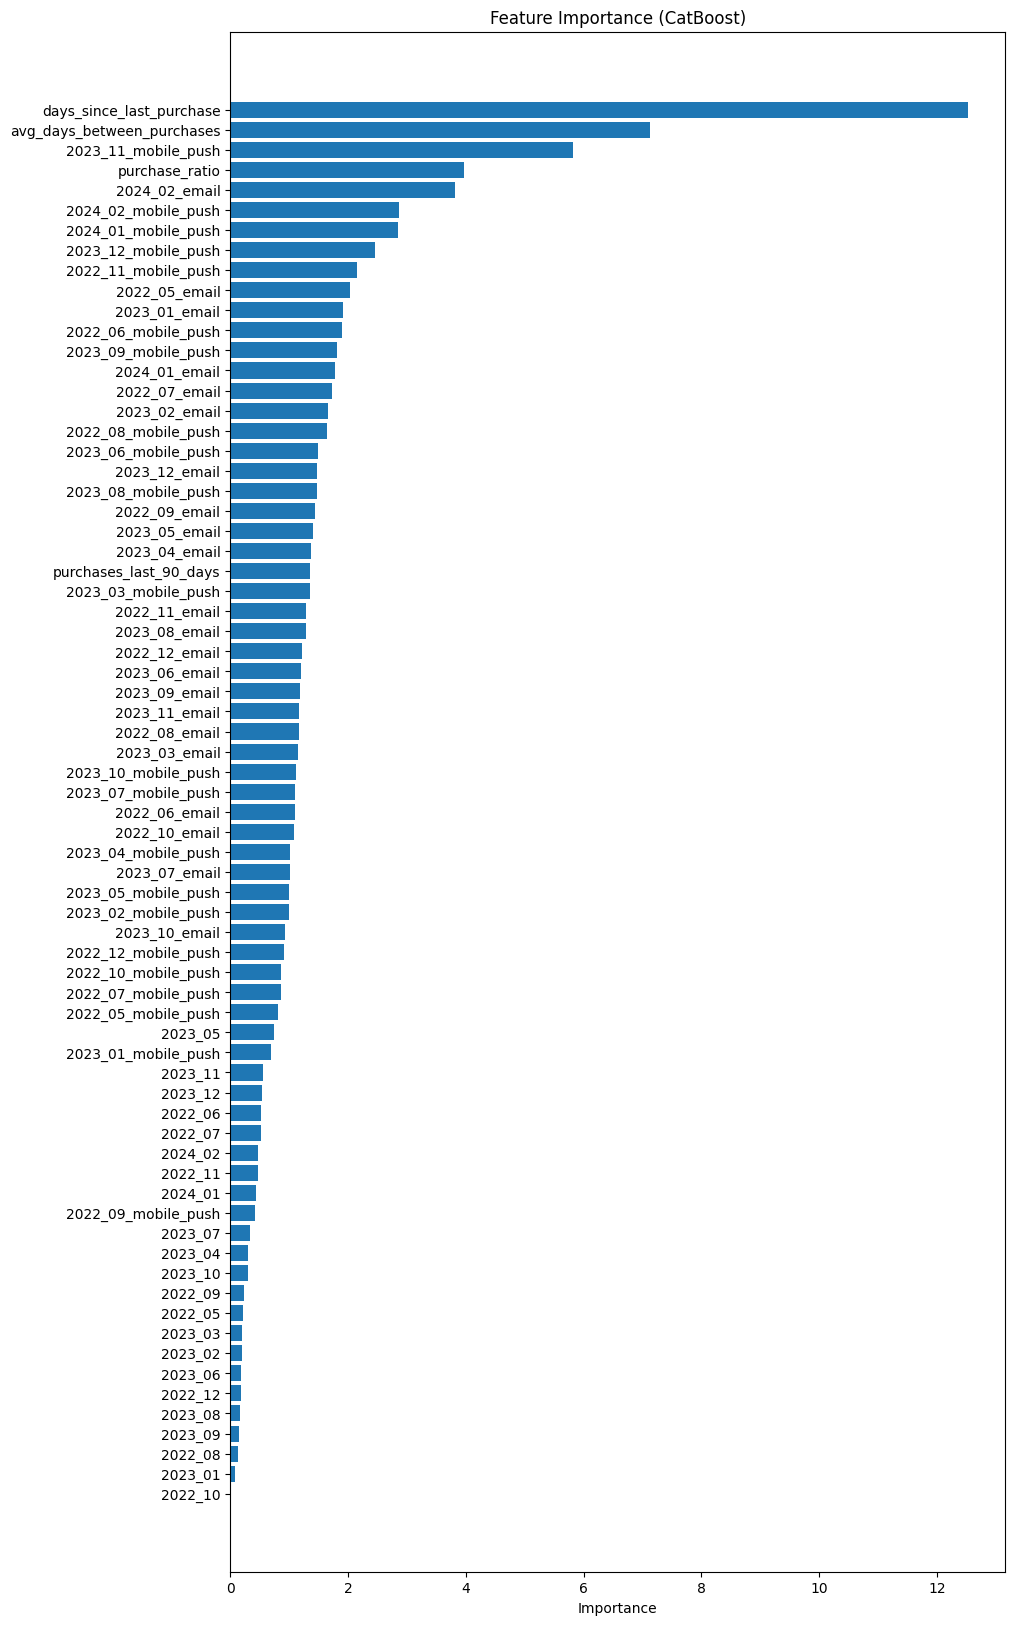

In [74]:
plt.figure(figsize=(10,20))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance (CatBoost)')
plt.show()

In [ ]:
pipe_xgb_final = Pipeline([
    ('scaler', 'passthrough'),
    ('model', XGBClassifier(
        random_state=RANDOM_STATE,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        n_jobs=-1
    ))
])

param_xgb_final = {
    'model__n_estimators': [200, 400, 600],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.03, 0.1],
    'model__subsample': [0.7, 0.85, 1.0],
    'model__colsample_bytree': [0.7, 0.85, 1.0],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.3]
}

search_xgb = RandomizedSearchCV(
    pipe_xgb_final,
    param_distributions=param_xgb_final,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search_xgb.fit(X_train, y_train)

print('Лучшие гиперпараметры XGBoost:\n')
for param, value in search_xgb.best_params_.items():
    print(f'{param}: {value}')

print(f'\nЛучший ROC-AUC (XGBoost): {search_xgb.best_score_:.4f}')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
